In [1]:
import tensorflow as tf
import h5py
import numpy as np
import imageio
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0) # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

from sketch2code.datasets import *

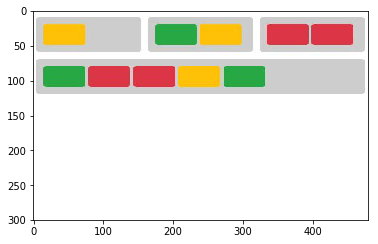

In [3]:
tags, images = load_dataset("toy")
plt.imshow(images[0])